# Análise Exploratória dos Dados (EDA)

### 1. Introdução ao RAVDESS Dataframe

#### Aqui está um exemplo de um nome de arquivo de áudio conforme descrito no site oficial do RAVDESS:
    - Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
    - Vocal channel (01 = speech, 02 = song).
    - Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
    - Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
    - Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
    - Repetition (01 = 1st repetition, 02 = 2nd repetition).
    - Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

#### Aqui está um exemplo do aúdio 02-01-06-01-02-01-12.mp4. Isso significa que os metadados para esse arquivo de áudio são:
    - Video-only (02)
    - Speech (01)
    - Fearful (06)
    - Normal intensity (01)
    - Statement "dogs" (02)
    - 1st Repetition (01)
    - 12th Actor (12) - Female (as the actor ID number is even)

### 2. Criando um DataFrame sobre os arquivos de áudio do dataset RAVDESS

#### 2.1. Importando as bibliotecas

In [1]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
import os
import glob


#### 2.2. Criando o dataframe

In [3]:
Ravdess = 'D:/trilha/mini_projeto2/Audio_Speech_Actors_01-24/' # Mude para o seu path

In [4]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # As their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # Third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0  neutral  D:/trilha/mini_projeto2/Audio_Speech_Actors_01...
1  neutral  D:/trilha/mini_projeto2/Audio_Speech_Actors_01...
2  neutral  D:/trilha/mini_projeto2/Audio_Speech_Actors_01...
3  neutral  D:/trilha/mini_projeto2/Audio_Speech_Actors_01...
4     calm  D:/trilha/mini_projeto2/Audio_Speech_Actors_01...

### 3. Limpeza dos Dados
- Agora que criamos o nosso Dataframe, precisamos nos certificar que ele está limpo de erros e pronto para os próximos passos.

#### 3.1. Verificando se há arquivos corrompidos, muito curtos ou com problemas de leitura

In [6]:
def check_audio_files(df):
    valid_files = []
    invalid_files = []
# Vai percorrer cada linha do dataframe, e a cada volta do loop, row vai conter as linhas do df
    for index, row in df.iterrows():
            
            audio_data, sample_rate = librosa.load(row['Path'])
            if len(audio_data) > 0:
                valid_files.append(row['Path'])
            else:
                invalid_files.append(row['Path'])
    

    return valid_files, invalid_files
    return valid_files, invalid_files

# Verificar os arquivos do dataset
valid_files, invalid_files = check_audio_files(Ravdess_df)

# Filtrar o DataFrame para manter apenas os arquivos válidos
Ravdess_df = Ravdess_df[Ravdess_df["Path"].isin(valid_files)]

print(f"Arquivos válidos: {len(valid_files)}")
print(f"Arquivos inválidos/removidos: {len(invalid_files)}")

Arquivos válidos: 1440
Arquivos inválidos/removidos: 0


### 4. Exploração e Visualização dos Dados

#### 4.1. Visualizando quais são as principais emoções presentes em nosso dataframe

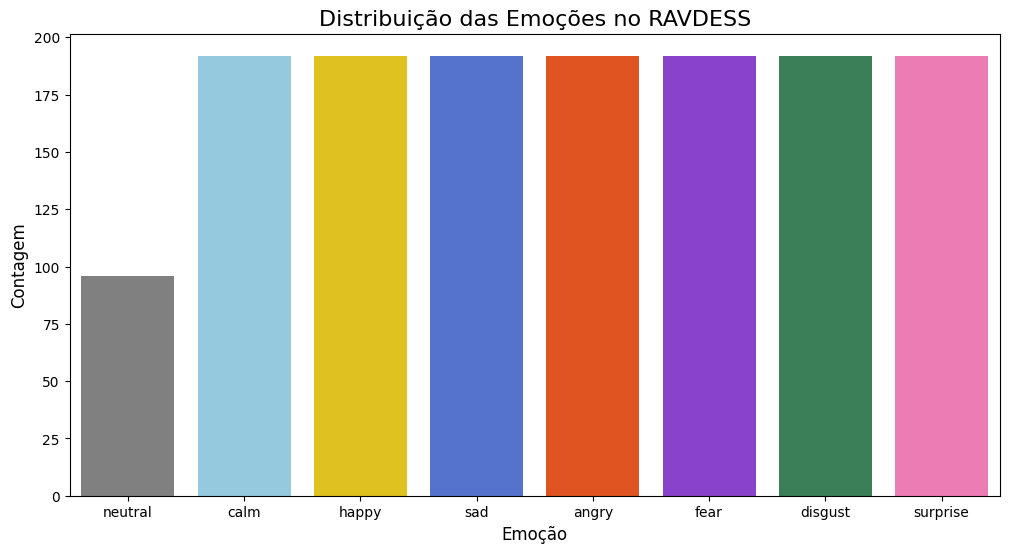

In [ ]:
# Plote um gráfico mostrando as principais emoções do dataframe

plt.figure(figsize=(12, 6))
# Criei uma paletta propria, para cada emoção ter sua cor.
minha_palette = sns.color_palette([
    "#808080", 
    "#87CEEB",  
    "#FFD700", 
    "#4169E1", 
    "#FF4500",  
    "#8A2BE2",
    "#2E8B57",  
    "#FF69B4"  
])

plt.title('Distribuição das Emoções no RAVDESS', fontsize=16)
sns.countplot(x='Emotions', data=Ravdess_df, palette=minha_palette)

plt.xlabel('Emoção', fontsize=12)
plt.ylabel('Contagem', fontsize=12)

plt.show()

#### 4.2. Plotando o sinal de aúdio em forma de onda e em espectograma
- Forma de Onda - Os Waveplots nos permitem visualizar a intensidade (volume) do áudio em um determinado momento.
- Espectrogramas - Um espectrograma é uma representação visual do espectro de frequências de um som ou de outros sinais à medida que variam ao longo do tempo. Ele mostra como as frequências mudam em relação ao tempo para um determinado sinal de áudio.

In [9]:
def create_waveplot(data, sr, e):
    # Use a função waveshow do librosa para isso e não se esqueça de colocar um título 
    # Code here
    """
    Criar e exibir um gráfico de forma de onda (waveplot) para um sinal de áudio.

    Parâmetros:
    data (np.ndarray): O array com os dados do áudio (série temporal).
    sr (int): A taxa de amostragem do áudio.
    e (str): A emoção associada ao áudio (para o título do gráfico).
    """
    plt.figure(figsize=(12, 4))

    plt.title(f'Forma de Onda (Waveplot) - Emoção: {e.capitalize()}', fontsize=14)
    
    # Função para plotar os dados
    librosa.display.waveshow(y=data, sr=sr, color='purple')

    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()




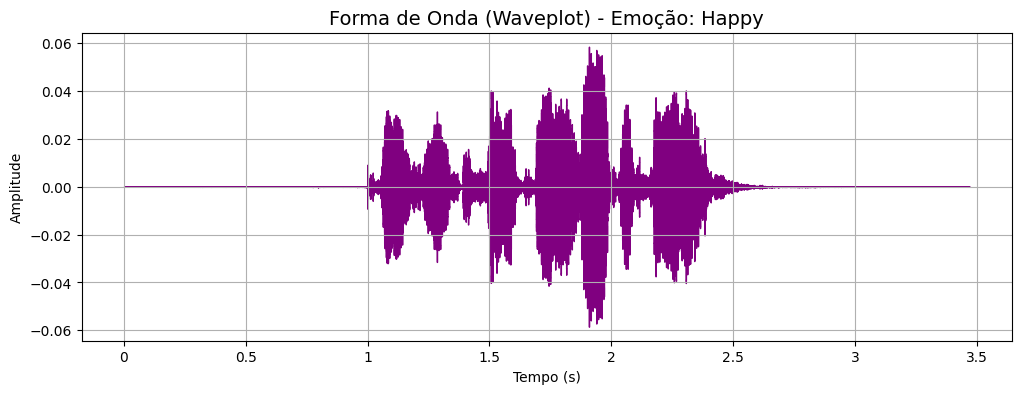

In [11]:
# Exemplo, para ver se tá rodando

# Primeiro, filtramos o DataFrame para pegar um exemplo de emoção, nesse caso 'happy'

""" Nesse caso, se cria uma condição de busca, que basicamente vai verificar cada linha da coluna 'emotions' e se for happy, retorna true e se não false.
A segunda parte, basicamente faz com que retorne uma lista com todos os audios felizes, mas o codigo vai pegar especificamente o que vêm primeiro"""

happy_audio_path = Ravdess_df[Ravdess_df['Emotions'] == 'happy']['Path'].iloc[0]
# apenas atribuição de variável
happy_emotion_label = 'happy'

# Carrega os dados do áudio
audio_data, sample_rate = librosa.load(happy_audio_path)


# Esses são os dados carregados, a taxa de amostragem e a emoção para a função.
create_waveplot(data=audio_data, sr=sample_rate, e=happy_emotion_label)

In [12]:
def create_spectrogram(data, sr, e):
    # Use a função stft do librosa para transformar os dados e a specshow para plotar o gráfico
    # STFT function converts the data into Short Term Fourier Transform
    
    plt.figure(figsize=(12, 4))
    

    X = librosa.stft(data)
    
    # Converte a amplitude para uma escala de decibéis (dB)
    Xdb = librosa.amplitude_to_db(abs(X))
    
    # Usa a função specshow para plotar o espectrograma
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log', cmap='viridis')
    
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Espectrograma - Emoção: {e.capitalize()}', fontsize=14)
    plt.xlabel('Tempo (s)')
    plt.ylabel('Frequência (Hz)')
    plt.show()


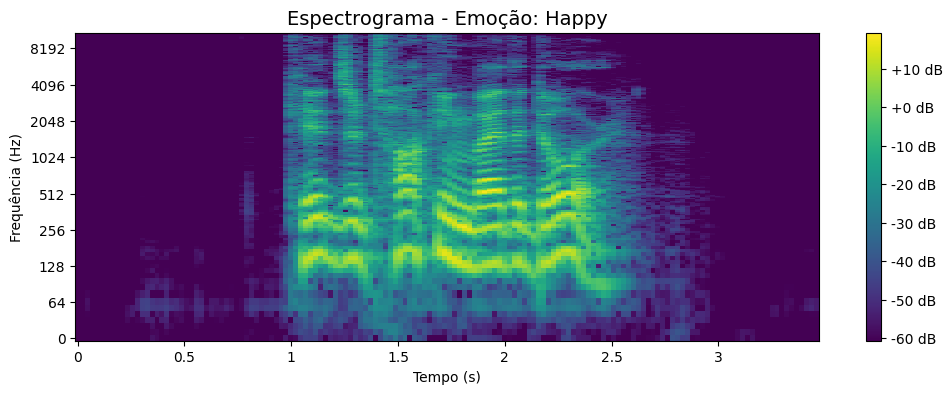

In [17]:

# Testando, assim como no outro exemplo

audio_data, sample_rate = librosa.load(happy_audio_path)
create_spectrogram(data=audio_data, sr=sample_rate, e=happy_emotion_label)


#### Agora rode as células abaixo para ver os resultados do que você fez :)

#### Emoção de Medo

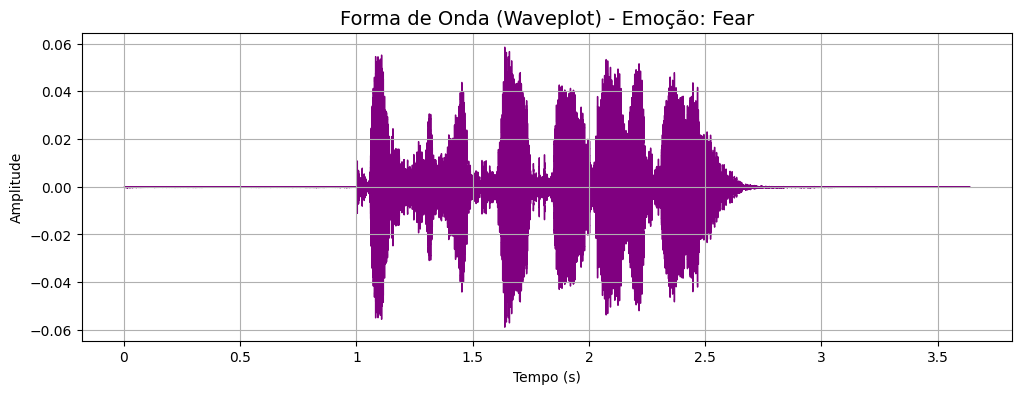

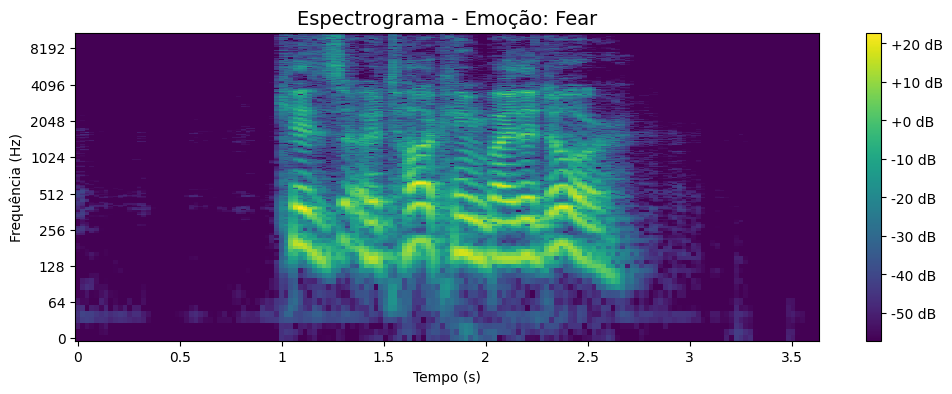

In [15]:
emotion='fear'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

#### Emoção de felicidade

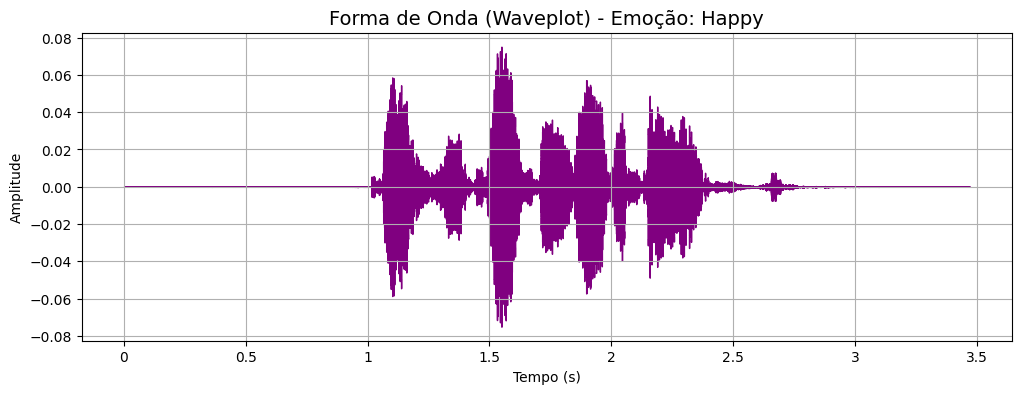

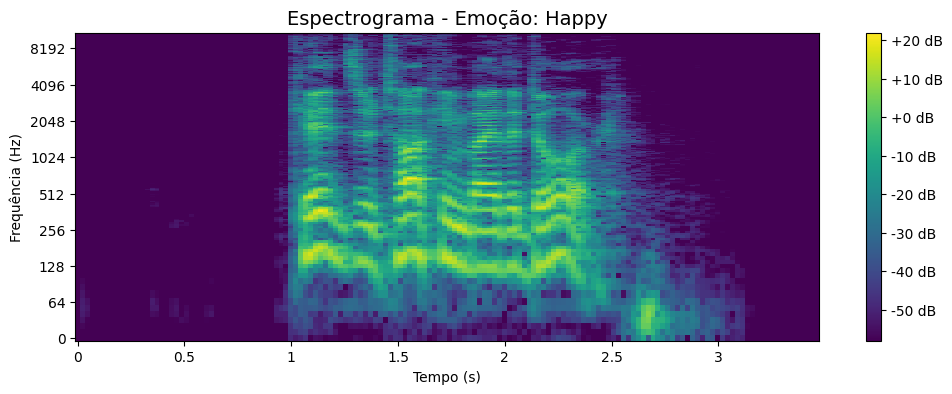

In [18]:
emotion='happy'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

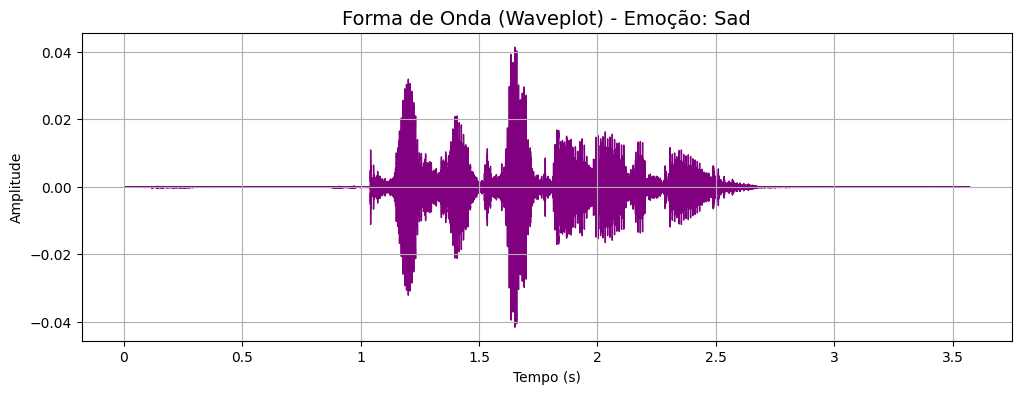

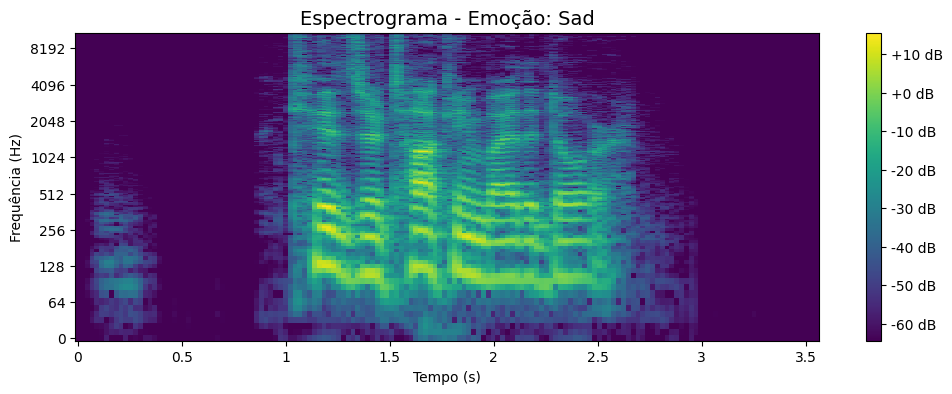

In [26]:
emotion='sad'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
emotion='angry'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
emotion='calm'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
emotion='neutral'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
emotion='disgust'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
emotion='suprise'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

#### 4.3. Analisar a duração dos áudios

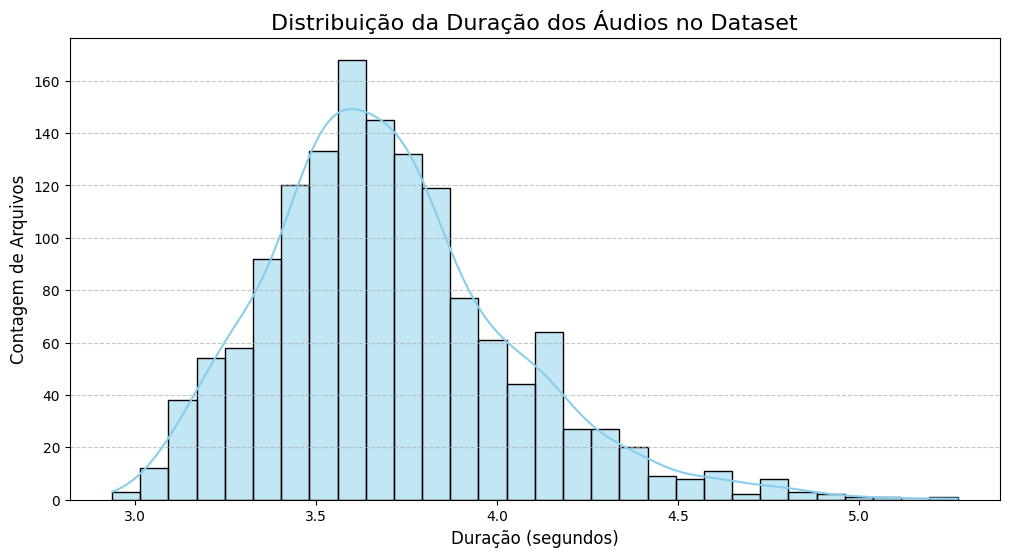

In [22]:
# Plote um histograma para ver como está a distribuição da duração dos aúdios no dataset

# Usamos a função librosa.get_duration(), para carregar a duração do á udio.
durations = [librosa.get_duration(path=path) for path in Ravdess_df['Path']]
# Atribui a lista à nova coluna do DataFrame
Ravdess_df['duration'] = durations

plt.figure(figsize=(12, 6))
plt.title('Distribuição da Duração dos Áudios no Dataset', fontsize=16)
sns.histplot(data=Ravdess_df, x='duration', bins=30, kde=True, color='skyblue')

plt.xlabel('Duração (segundos)', fontsize=12)
plt.ylabel('Contagem de Arquivos', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

### 5. Aumento de Dados (Data Augmentation)
- O aumento de dados é o processo pelo qual criamos novas amostras sintéticas de dados adicionando pequenas perturbações ao nosso conjunto de treinamento original.
- Para gerar dados sintéticos para áudio, podemos aplicar injeção de ruído, deslocamento no tempo, alteração de tom (pitch) e velocidade.
- O objetivo é tornar nosso modelo invariante a essas perturbações e melhorar sua capacidade de generalização.
- Para que isso funcione, as perturbações adicionadas devem manter o mesmo rótulo da amostra de treinamento original.
- No caso de imagens, o aumento de dados pode ser realizado por meio de deslocamento, zoom, rotação, entre outras técnicas.

Agora, vamos verificar quais técnicas de aumento de dados funcionam melhor para o nosso conjunto de dados :)

In [25]:
def noise(data):
    # Gere um valor de amplitude de ruído (baseado no valor máximo no dataset) e adicione ruído normal (gaussiano) ao dataset original
    noise_factor = 0.005
    # Pegamos o valor máximo absoluto do sinal e o multiplicamos pelo fator de ruído.
    noise_amplitude = noise_factor * np.max(np.abs(data))
    gaussian_noise = np.random.normal(loc=0, scale=noise_amplitude, size=data.shape)
    
    augmented_data = data + gaussian_noise
    
    return augmented_data




In [43]:
def stretch(data, rate=0.8):
    # Utilize a função librosa.effects.time_stretch para esticar ou comprimir o áudio pelo fator de taxa especificado.
       return librosa.effects.time_stretch(y=data, rate=rate)
    
 

In [28]:
def shift(data):
    # Determine um valor de deslocamento aleatório dentro de um intervalo e use np.roll para deslocar o dataset.
    intervalo = (-5, 5)
    deslocamento = np.random.randint(intervalo[0], intervalo[1] + 1)

    dataset_deslocado = np.roll(data, deslocamento)
    
    return dataset_deslocado


In [29]:
def pitch(data, sampling_rate, pitch_factor=0.7):
    # Aplique a função librosa.effects.pitch_shift para mudar o pitch do áudio pelo fator especifícado
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)


In [30]:
# Taking any example and checking for techniques.
path = np.array(Ravdess_df.Path)[1]
data, sample_rate = librosa.load(path)

In [33]:
def augment_audio(data, sr):
    return {
        'stretched': librosa.effects.time_stretch(data, rate=0.8),
        'pitch': librosa.effects.pitch_shift(data, sr=sr, n_steps=2),
        'noisy': data + np.random.normal(0, 0.05 * np.max(data), data.shape),
        'shifted': np.roll(data, np.random.randint(-5000, 5000))
    }

In [35]:
path = np.array(Ravdess_df.Path)[1]
data, sr = librosa.load(path, sr=None)  # sr=None mantém a taxa original do

augmented = augment_audio(data, sr)

In [36]:
for tipo, audio in augmented.items():
    print(f"{tipo}: shape = {audio.shape}")

stretched: shape = (200200,)
pitch: shape = (160160,)
noisy: shape = (160160,)
shifted: shape = (160160,)


#### 5.1. Simple Audio

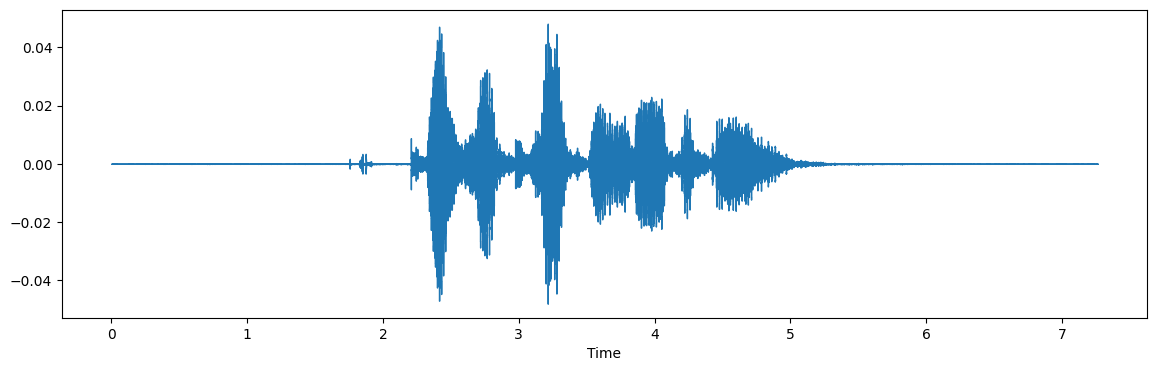

In [37]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 5.2. Noise Injection (Injeção de ruído)

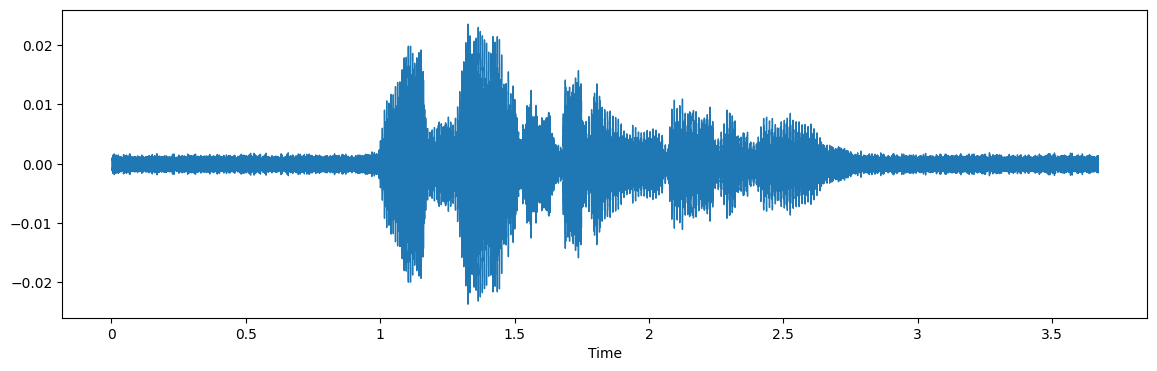

In [12]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5.3. Stretching (Alongamento)
- Mudando a velocidade do aúdio

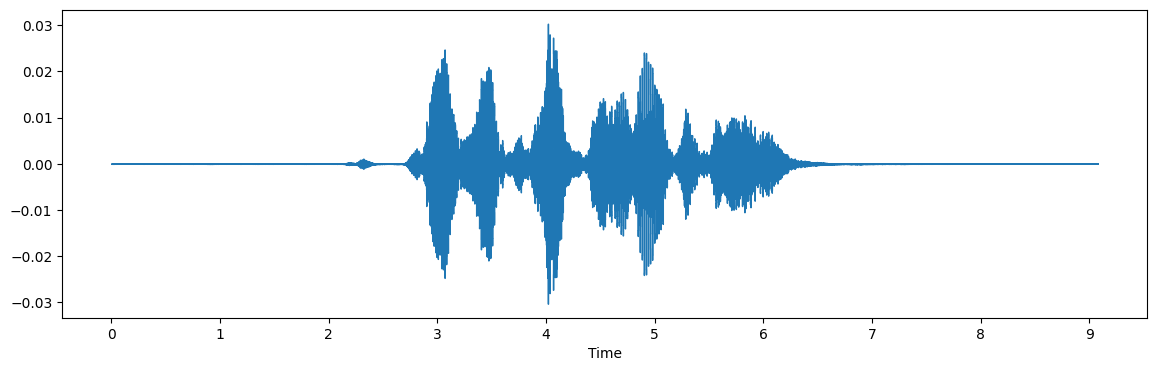

In [44]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5.4. Shifting (Deslocamento)
- Estou deslocando o sinal de áudio no tempo

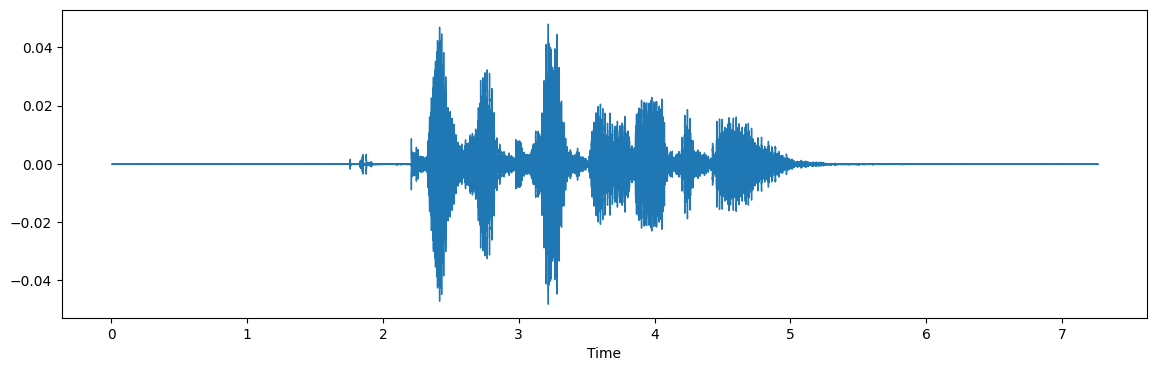

In [45]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5.5. Pitch (Tom)

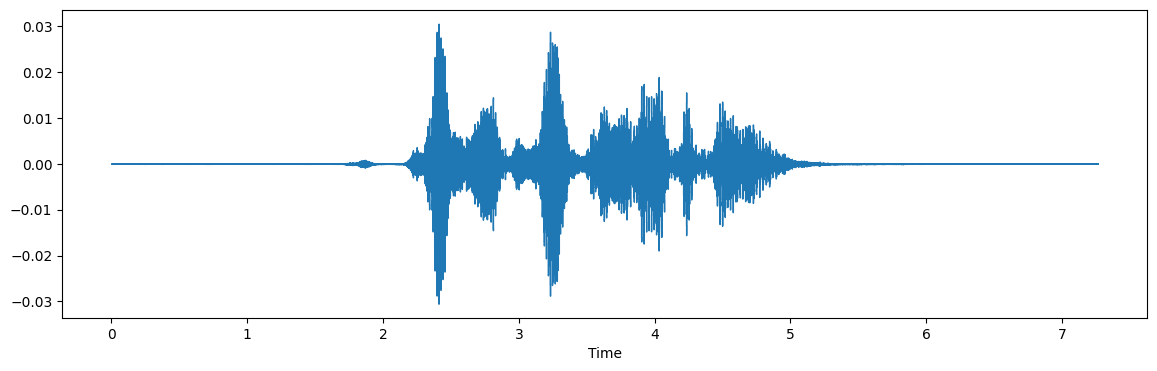

In [46]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### 6. Preparando o dataframe para a extração das features

#### 6.1. Função para Padronizar Áudios

In [50]:
import soundfile as sf 

def preprocess_and_save_audio(input_path, output_dir, target_sr=16000):
    """
    Padroniza e salva os arquivos de áudio.
    
    Args:
    - input_path (str): Caminho do arquivo de entrada.
    - output_dir (str): Diretório para salvar o arquivo processado.
    - target_sr (int): Taxa de amostragem desejada (default: 16000).
    
    Retorna:
    - str: Caminho do arquivo processado.
    """
    os.makedirs(output_dir, exist_ok=True)
    try:
        # Carregue o áudio com librosa.load e converta para mono
        audio, sr = librosa.load(input_path, sr=target_sr, mono=True)

        # Determine o output_path, combinando o diretório de saída com o nome do arquivo de entrada
        filename = os.path.basename(input_path)
        output_path = os.path.join(output_dir, filename)

        # Salvar o áudio processado
        sf.write(output_path, audio, target_sr)
        return output_path
    except Exception as e:
        print(f"Erro ao processar {input_path}: {e}")
        return None

#### 6.2. Aplicar a Padronização a Todos os Áudios

In [51]:
# Definir o caminho correto para salvar os áudios processados na pasta 'data' na raiz do projeto
processed_audio_dir = os.path.join(os.path.dirname(os.getcwd()), "data", "processed_audio")

# Criar o diretório se não existir
os.makedirs(processed_audio_dir, exist_ok=True)

print(f"Os arquivos serão salvos em: {processed_audio_dir}")


# Processar todos os áudios e salvar os novos caminhos
Ravdess_df["Processed_Path"] = Ravdess_df["Path"].apply(
    lambda x: preprocess_and_save_audio(x, processed_audio_dir)
)

# Remover arquivos que falharam no processamento
Ravdess_df = Ravdess_df[Ravdess_df["Processed_Path"].notnull()]

Os arquivos serão salvos em: d:\trilha\mini_projeto2\miniprojeto2\data\processed_audio


#### 6.3. Salvar o DataFrame Final

In [52]:
# Garantir que a pasta 'data' exista 
data_dir = os.path.join(os.path.dirname(os.getcwd()), "data")
os.makedirs(data_dir, exist_ok=True)

# Caminho correto para salvar o CSV na pasta 'data'
csv_path = os.path.join(data_dir, "ravdess_preprocessed.csv")

# Salvar o DataFrame no local correto, usa a função to_csv do pandas :)
# Code here

print(f"O arquivo foi salvo em: {csv_path}")

O arquivo foi salvo em: d:\trilha\mini_projeto2\miniprojeto2\data\ravdess_preprocessed.csv


### Isso é tudo por aqui, você fez um ótimo trabalho e está indo muito bem!
#### Estamos prontos para o pŕoximo notebook, mas antes vamos ver as coisas que aprendemos até então:
- Criamos o dataframe (você mudou o path e entendeu a cara do nosso dataframe)
- Limpamos os dados (verificamos se existiam aúdios corrompidos)
- Plotamos gráficos (fizemos uns gráficos bem bonitos sobre o dataframe)
- Data augmentation (aplicamos algumas funções no aúdio para aumentar a quantidade de dados)
- Salvamos um dataframe com pandas (usamos to_csv)